In [ ]:
%%time                        
import pandas as pd              #Расчет Гиперпараметров
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Блок 1: Загрузка данных и предварительная обработка
data = pd.read_csv('C:/Users/bondarenKovv/Desktop/Python/Прогноз Магазины/Sales.csv', sep=';', low_memory=False)
data['Дата'] = pd.to_datetime(data['Дата'], dayfirst=True)
data = data[(data['Дата'] >= '2021-01-01')]

# Подготовка данных для модели Prophet
data = data.rename(columns={'Дата': 'ds', 'Номер Магазина': 'store', '(Сутки).(Сумма продаж в фактических ценах реализации(валюта))': 'y'})
data['y'] = data['y'].str.replace(',', '.').astype(float)

# Блок 2: Определение функции для оценки модели
def evaluate_model(data, params):
    model = Prophet(**params)
    model.fit(data)
    df_cv = cross_validation(model, horizon='30 days')
    df_p = performance_metrics(df_cv)
    return df_p['mape'].mean()

# Блок 3:Исключенные закрытых магазинов

excluded_stores = [149, 155, 164, 111, 123]  # Исключение магазинов из расчета

# Блок 4: Проверка достаточности данных для вычисления гиперпараметров
if len(data) < 50 * len(data['store'].unique()):  
    df_cv = cross_validation(model, horizon='15 days')

# Блок 5: Расчет гиперпараметров модели
model_params = {}
for store in data['store'].unique():
    if store in excluded_stores:
        continue

    store_data = data[data['store'] == store]
    best_mape = float('inf')
    best_params = None

    for changepoint_prior_scale in [0.001, 0.01, 0.1, 0.25, 0.5, 1.0, 2.5]:
        for seasonality_prior_scale in [1.0, 10.0, 20.0, 50.0, 100.0]:
            for seasonality_mode in ['additive', 'multiplicative']:     #Аддитивная модель=Сезенность +Тренд. Мультипликативная=Сезонность*Тренд
                params = {'changepoint_prior_scale': changepoint_prior_scale,
                          'seasonality_prior_scale': seasonality_prior_scale,
                          'seasonality_mode': seasonality_mode}
                mape = evaluate_model(store_data, params)
                if mape < best_mape:
                    best_mape = mape
                    best_params = params
    model_params[store] = best_params

# Сохранение параметров модели в файл
param_data = pd.DataFrame.from_dict(model_params, orient='index').reset_index()
param_data.columns = ['store', 'changepoint_prior_scale', 'seasonality_prior_scale','seasonality_mode']
param_data.to_excel('model_params.xlsx', index=False)

In [ ]:
param_data = pd.DataFrame.from_dict(model_params, orient='index').reset_index()        #Сохранение Гиперпараметров на случай ошибки
param_data.columns = ['store', 'changepoint_prior_scale', 'seasonality_prior_scale','seasonality_mode']
param_data.to_excel('model_params.xlsx', index=False)

In [4]:
%%time
import warnings
import pandas as pd             #Расчет прогноза
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

warnings.filterwarnings("ignore")

# Блок 1: Загрузка данных и предварительная обработка
data = pd.read_csv('C:/Users/bondarenKovv/Desktop/Python/Прогноз Магазины/Sales.csv', sep=';', low_memory=False)
data['Дата'] = pd.to_datetime(data['Дата'], dayfirst=True)
data = data[(data['Дата'] >= '2021-01-01')]

# Подготовка данных для модели Prophet
data = data.rename(columns={'Дата': 'ds', 'Номер Магазина': 'store', '(Сутки).(Сумма продаж в фактических ценах реализации(валюта))': 'y'})
data['y'] = data['y'].str.replace(',', '.').astype(float)

# Фильтрация данных для магазинов, которые присутствуют в DataFrame
store_ids = [180, 181, 183, 184]
other_store_data = data[~data['store'].isin(store_ids)]
specified_store_data = data[data['store'].isin(store_ids)]

# Удаление строк с пропущенными значениями
other_store_data.dropna(inplace=True)
specified_store_data.dropna(inplace=True)

# Блок 2: Загрузка гиперпараметров модели
try:
    model_params = pd.read_excel('model_params.xlsx')
except FileNotFoundError:
    model_params = pd.DataFrame(columns=['store', 'changepoint_prior_scale', 'seasonality_prior_scale','seasonality_mode'])

# Блок 3: Предпраздничные даты и исключенные магазины
pre_holiday_dates = ['2024-02-22','2024-03-07','2024-05-08','2024-06-11','2024-04-30','2024-05-03','2024-05-04','2024-06-22','2024-04-09','2024-06-15']  # Добавьте нужные даты
excluded_stores = [149, 155, 164, 111, 123]  # Исключение магазинов из расчета

# Блок 4: Прогнозирование для магазинов, для которых указаны гиперпараметры
all_forecasts = pd.DataFrame()
for _, params in model_params.iterrows():
    store = params['store']
    if store in excluded_stores:
        continue

    store_data = other_store_data[other_store_data['store'] == store]

    model = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_prior_scale=params['seasonality_prior_scale'],
                    seasonality_mode=params['seasonality_mode'])
    model.fit(store_data)
                                               
    future = model.make_future_dataframe(periods=40)
    forecast = model.predict(future)
    forecast['store'] = store

    # Увеличение прогноза для каждой предпраздничной даты
    for pre_holiday_date in pre_holiday_dates:
        mask = forecast['ds'] == pd.to_datetime(pre_holiday_date)
        forecast.loc[mask, 'yhat'] *= 1.2  # Увеличение на 20%

    all_forecasts = pd.concat([all_forecasts, forecast])

# Блок 5: Прогнозирование для магазинов 180, 181, 183 с использованием стандартных гиперпараметров
for store in store_ids:
    store_data = specified_store_data[specified_store_data['store'] == store]

    model = Prophet()
    model.fit(store_data)
                                               # на 40 дней вперед
    future = model.make_future_dataframe(periods=40)
    forecast = model.predict(future)
    forecast['store'] = store

    # Увеличение прогноза для каждой предпраздничной даты
    for pre_holiday_date in pre_holiday_dates:
        mask = forecast['ds'] == pd.to_datetime(pre_holiday_date)
        forecast.loc[mask, 'yhat'] *= 1.2  # Увеличение на 20%

    all_forecasts = pd.concat([all_forecasts, forecast])

# Сохранение результатов прогноза в новом Excel-файле
selected_columns = ['ds', 'store', 'yhat', 'yhat_upper']
all_forecasts[selected_columns].to_excel('forecast_next_month.xlsx', index=False)

09:24:36 - cmdstanpy - INFO - Chain [1] start processing
09:24:36 - cmdstanpy - INFO - Chain [1] done processing
09:24:37 - cmdstanpy - INFO - Chain [1] start processing
09:24:37 - cmdstanpy - INFO - Chain [1] done processing
09:24:37 - cmdstanpy - INFO - Chain [1] start processing
09:24:37 - cmdstanpy - INFO - Chain [1] done processing
09:24:38 - cmdstanpy - INFO - Chain [1] start processing
09:24:38 - cmdstanpy - INFO - Chain [1] done processing
09:24:38 - cmdstanpy - INFO - Chain [1] start processing
09:24:38 - cmdstanpy - INFO - Chain [1] done processing
09:24:39 - cmdstanpy - INFO - Chain [1] start processing
09:24:39 - cmdstanpy - INFO - Chain [1] done processing
09:24:39 - cmdstanpy - INFO - Chain [1] start processing
09:24:39 - cmdstanpy - INFO - Chain [1] done processing
09:24:40 - cmdstanpy - INFO - Chain [1] start processing
09:24:40 - cmdstanpy - INFO - Chain [1] done processing
09:24:40 - cmdstanpy - INFO - Chain [1] start processing
09:24:41 - cmdstanpy - INFO - Chain [1]

CPU times: total: 3min
Wall time: 1min 33s


In [5]:
# Блок 6: Оценка точности прогнозирования

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

store_id = 121  # Замените на конкретный ID магазина
store_forecast = all_forecasts[all_forecasts['store'] == store_id]
actual_sales = other_store_data[other_store_data['store'] == store_id]

# Объединяем прогнозы с фактическими продажами по дате
merged_data = pd.merge(store_forecast, actual_sales, how='left', left_on='ds', right_on='ds', suffixes=('_forecast', '_actual'))

# Удаляем строки с пропущенными значениями
merged_data.dropna(subset=['y'], inplace=True)

# Рассчитываем ошибки прогноза
merged_data['error'] = merged_data['yhat'] - merged_data['y']

# Рассчитываем метрики точности прогнозирования
mae = mean_absolute_error(merged_data['y'], merged_data['yhat'])
rmse = np.sqrt(mean_squared_error(merged_data['y'], merged_data['yhat']))
mape = np.mean(np.abs((merged_data['y'] - merged_data['yhat']) / merged_data['y'])) * 100

print("MAE:", mae) #MAE измеряет среднее абсолютное отклонение между прогнозными значениями и фактическими значениями. Она рассчитывается как сумма абсолютных разностей между прогнозами и фактическими значениями, деленная на общее количество наблюдений
print("RMSE:", rmse) #RMSE измеряет среднеквадратичное отклонение между прогнозными значениями и фактическими значениями. Она рассчитывается как корень из среднего квадрата разностей между прогнозами и фактическими значениями
print("MAPE:", mape) #MAPE измеряет среднее абсолютное процентное отклонение между прогнозными значениями и фактическими значениями. Она рассчитывается как среднее значение абсолютных процентных разностей между прогнозами и фактическими значениями. 


MAE: 31862.081407215785
RMSE: 45648.59130193524
MAPE: 8.626177609938763


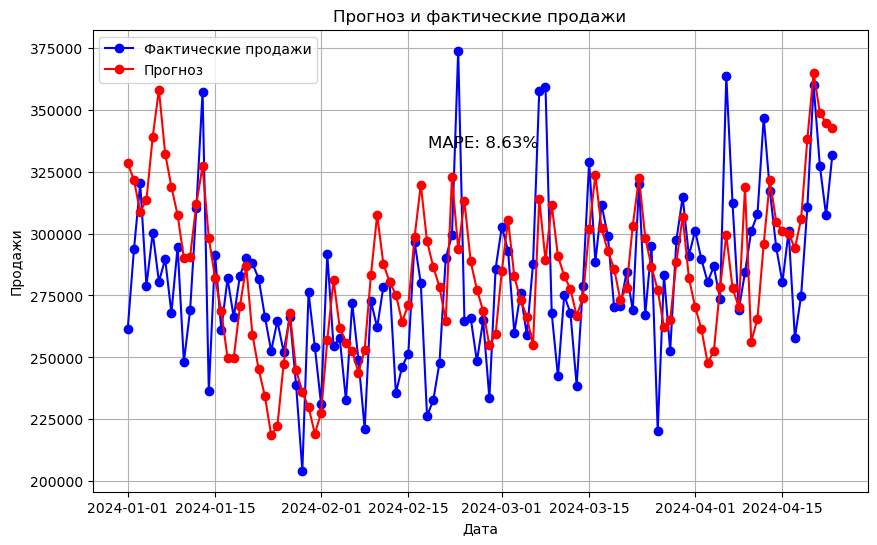

In [6]:
# Блок 7: Визуализация прогноза

import matplotlib.pyplot as plt

# Фильтруем данные, оставляем только строки после 01.01.2024 года
merged_data_valid = merged_data[merged_data['ds'] >= '2024-01-01']

# Создаем график
plt.figure(figsize=(10, 6))

# Строим фактические продажи
plt.plot(merged_data_valid['ds'], merged_data_valid['y'], label='Фактические продажи', color='blue', marker='o', linestyle='solid')

# Строим прогнозные значения, которые засчитались
plt.plot(merged_data_valid['ds'], merged_data_valid['yhat'], label='Прогноз', color='red', marker='o', linestyle='solid')

# Добавляем аннотацию с показателем MAPE в центре графика
plt.text(merged_data_valid['ds'].iloc[int(len(merged_data_valid)/2)], 
         merged_data_valid['y'].max() * 0.9, 
         f'MAPE: {mape:.2f}%', 
         ha='center', va='center', fontsize=12)

# Настройки графика
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.title('Прогноз и фактические продажи')
plt.legend()
plt.grid(True)

# Отображаем график
plt.show()